In [23]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
from pinecone import Pinecone, ServerlessSpec
from transformers import BertTokenizer, BertModel
import torch


pc = Pinecone(api_key="12f9969a-20b1-4ff4-abb3-7f492c8ff12a")

Embeding

In [12]:
# Load dataset
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
# Initialize BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def embed_batch(batch_texts):
    inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128, pad_to_max_length=True)
    with torch.no_grad():  # Disable gradient calculation for faster inference
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()

# Process a larger number of entries (e.g., 5000)
num_entries = 5000
texts = df['review'].tolist()[:num_entries]
dataset = TextDataset(texts)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

embeddings = []
for batch_texts in dataloader:
    batch_embeddings = embed_batch(batch_texts)
    embeddings.extend(batch_embeddings)

# Convert embeddings to a list of lists for storage in DataFrame
df['embedding'] = pd.Series(embeddings[:num_entries])

# Save the embeddings to a CSV file
df[['review', 'sentiment', 'embedding']].to_csv('IMDB_Dataset_with_Embeddings.csv', index=False)


/Users/nurwulanhandayani/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2722: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


In [ ]:
pengideksan data

In [24]:
pip install --upgrade urllib3


Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install --upgrade certifi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: certifi
    Found existing installation: certifi 2024.2.2
    Uninstalling certifi-2024.2.2:
      Successfully uninstalled certifi-2024.2.2
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pinecone
from pinecone import Pinecone, ServerlessSpec
from urllib3.util import Retry
from requests.adapters import HTTPAdapter
import requests
import time

# Initialize Pinecone
pc = Pinecone(api_key="12f9969a-20b1-4ff4-abb3-7f492c8ff12a")

# Index specifications
index_name = "imdb-movie-reviews"
dimension = 768  # Dimension of BERT embedding

# Check if the index exists
if index_name in pc.list_indexes():
    print(f"Index '{index_name}' already exists.")
    
    # Optionally delete the existing index if you want to recreate it
    pc.delete_index(index_name)
    print(f"Index '{index_name}' deleted.")
    
    # Create the new index with serverless specifications
    spec = ServerlessSpec(cloud="aws", region="us-east-1")
    pc.create_index(index_name, dimension=dimension, metric="cosine", spec=spec)
    print(f"Index '{index_name}' created.")
else:
    # Create the new index with serverless specifications if it does not exist
    spec = ServerlessSpec(cloud="aws", region="us-east-1")
    pc.create_index(index_name, dimension=dimension, metric="cosine", spec=spec)
    print(f"Index '{index_name}' created.")

# Connect to the index
index = pc.Index(index_name)

# Assuming you have your embeddings ready
# Upsert data to Pinecone
vectors = [(str(i), embeddings[i]) for i in range(len(embeddings))]

# Function to batch the vectors
def batch_vectors(vectors, batch_size):
    for i in range(0, len(vectors), batch_size):
        yield vectors[i:i + batch_size]

# Function to upsert with retries
def upsert_with_retries(index, vectors, max_retries=3, delay=5):
    for attempt in range(max_retries):
        try:
            for batch in batch_vectors(vectors, 100):  # Adjust batch size as needed
                index.upsert(batch)
            print(f"Data upserted to index '{index_name}'.")
            break
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt + 1 < max_retries:
                time.sleep(delay)
            else:
                print(f"Failed to upsert data after {max_retries} attempts.")
                raise

upsert_with_retries(index, vectors)


Index 'imdb-movie-reviews' created.
Data upserted to index 'imdb-movie-reviews'.


k-means clustering index

In [41]:
import pandas as pd

df_embeddings = pd.read_csv('IMDB_Dataset_with_Embeddings.csv')


In [42]:
import numpy as np

embedding_array = np.array(df_embeddings['embedding'].tolist())


In [44]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Muat dataset
df = pd.read_csv("IMDB Dataset.csv")

# Eksplorasi Data
print(df.head())

# Pra-pemrosesan Data
# Contoh pra-pemrosesan sederhana
# Anda mungkin perlu menyesuaikan ini sesuai kebutuhan Anda
def preprocess_text(text):
    # Ubah huruf menjadi huruf kecil
    text = text.lower()
    # Tokenisasi (gunakan tokenisasi yang sesuai)
    tokens = text.split()
    # Hapus karakter khusus dan angka
    tokens = [word for word in tokens if word.isalpha()]
    # Gabungkan kembali tokens menjadi kalimat
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

df['clean_text'] = df['review'].apply(preprocess_text)

# Vektorisasi
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])

# Pembagian Data
# Di sini kita tidak akan membagi data karena ini hanya contoh
# Namun, di dunia nyata, Anda harus membagi data menjadi set pelatihan dan pengujian
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pelatihan Model KMeans
# Gunakan metode Elbow untuk menentukan jumlah cluster yang optimal
# Ini adalah contoh kode untuk menentukan jumlah cluster terbaik
inertia = []
silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))

# Evaluasi jumlah cluster terbaik
# Anda bisa menggunakan metode Elbow atau metode lainnya untuk menentukan jumlah cluster terbaik
# Di sini saya hanya mencetak inertia dan skor silhouette untuk setiap jumlah cluster
print("Inertia:", inertia)
print("Silhouette Score:", silhouette)

# Setelah menentukan jumlah cluster terbaik, latih model KMeans
best_k = 5  # Misalnya, diasumsikan jumlah cluster terbaik adalah 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X)

# Evaluasi dan Interpretasi
# Di sini Anda dapat mengevaluasi hasil clustering dan mencoba memahami interpretasinya
# Misalnya, Anda dapat mencetak ulasan di setiap cluster untuk melihat apakah mereka memiliki sentimen yang serupa
# Anda juga dapat melakukan visualisasi dengan teknik seperti t-SNE atau PCA untuk melihat pengelompokan data secara grafis


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Inertia: [36010.649120383074, 35772.19349267936, 35551.346812942276, 35374.58493512365, 35246.14889004633, 35133.57360432712, 35051.945979384676, 34979.00574543864, 34915.68347010799]
Silhouette Score: [0.018483586406942254, -0.0033563299999101984, -0.0004849372081696581, -0.004620763156312528, -0.016103957550316707, -0.01733518830168285, -0.02103337894453624, -0.021779174902697214, -0.026270311440699384]


KMeans(n_clusters=5, random_state=42)

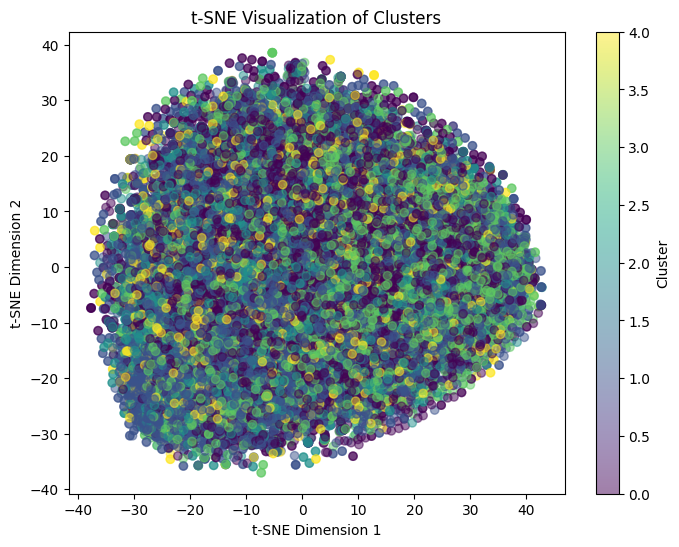


Cluster 0:
3    Basically there's a family where a little boy ...
5    Probably my all-time favorite movie, a story o...
6    I sure would like to see a resurrection of a u...
8    Encouraged by the positive comments about this...
9    If you like original gut wrenching laughter yo...
Name: review, dtype: object

Cluster 1:
0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
4     Petter Mattei's "Love in the Time of Money" is...
16    Some films just simply should not be remade. T...
19    An awful film! It must have been up against so...
Name: review, dtype: object

Cluster 2:
20    After the success of Die Hard and it's sequels...
30    Taut and organically gripping, Edward Dmytryk'...
31    "Ardh Satya" is one of the finest film ever ma...
48    Preston Sturgis' THE POWER AND THE GLORY was u...
51    ***SPOILERS*** All too, in real life as well a...
Name: review, dtype: object

Cluster 3:
2     I thought this was a wonder

In [51]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Visualisasi Hasil Clustering dengan t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Interpretasi Hasil Clustering
cluster_labels = kmeans.labels_
df['cluster_label'] = cluster_labels

for cluster_id in range(best_k):
    cluster_df = df[df['cluster_label'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(cluster_df.head(5)['review'])

# Evaluasi Eksternal (jika ada label ground truth)
# Misalnya, menggunakan Adjusted Rand Index
# from sklearn.metrics import adjusted_rand_score
# ari = adjusted_rand_score(true_labels, cluster_labels)
# print("Adjusted Rand Index:", ari)

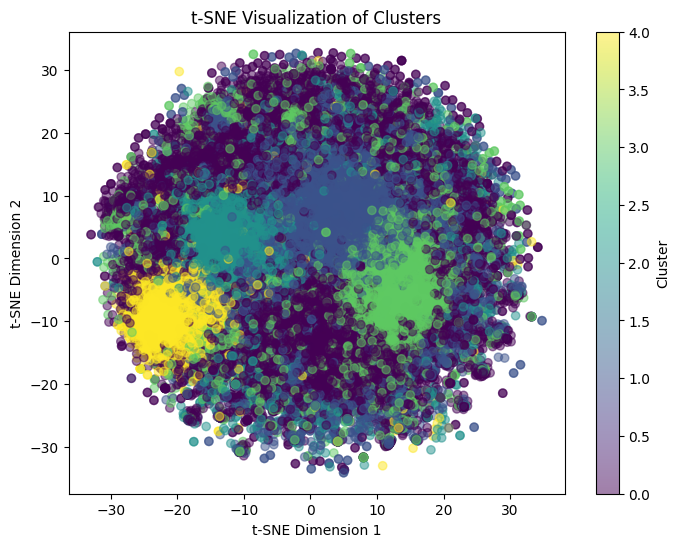


Cluster 0:
3    Basically there's a family where a little boy ...
5    Probably my all-time favorite movie, a story o...
6    I sure would like to see a resurrection of a u...
8    Encouraged by the positive comments about this...
9    If you like original gut wrenching laughter yo...
Name: review, dtype: object

Cluster 1:
0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
4     Petter Mattei's "Love in the Time of Money" is...
16    Some films just simply should not be remade. T...
19    An awful film! It must have been up against so...
Name: review, dtype: object

Cluster 2:
20    After the success of Die Hard and it's sequels...
30    Taut and organically gripping, Edward Dmytryk'...
31    "Ardh Satya" is one of the finest film ever ma...
48    Preston Sturgis' THE POWER AND THE GLORY was u...
51    ***SPOILERS*** All too, in real life as well a...
Name: review, dtype: object

Cluster 3:
2     I thought this was a wonder

In [53]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("IMDB Dataset.csv")

# Preprocessing
def preprocess_text(text):
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word.isalpha()]
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

df['clean_text'] = df['review'].apply(preprocess_text)

# Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])

# KMeans Clustering
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Dimensionality Reduction for Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Add cluster labels to DataFrame
df['cluster_label'] = cluster_labels

# Display cluster information
for cluster_id in range(best_k):
    cluster_df = df[df['cluster_label'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(cluster_df.head(5)['review'])

# Topic Modeling with LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

# Define and fit the LDA model
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Display the top words for each topic
num_top_words = 10
print("Top words for each topic:")
display_topics(lda_model, vectorizer.get_feature_names_out(), num_top_words)


# Query Based on Cluster
# You can query based on the cluster labels obtained from KMeans
# For example, to retrieve reviews from cluster 1:
cluster_label = 1
cluster_indices = df[df['cluster_label'] == cluster_label].index
cluster_reviews = df.loc[cluster_indices]['review']

# Query Based on Topic
# You can query based on the dominant topic probabilities obtained from LDA
# For example, to retrieve reviews dominated by topic 0:
topic_index = 0
topic_probabilities = lda_model.transform(X)
topic_indices = topic_probabilities.argmax(axis=1)
topic_reviews_indices = [i for i, idx in enumerate(topic_indices) if idx == topic_index]
topic_reviews = df.iloc[topic_reviews_indices]['review']


Pembuatan Query


In [35]:

# Example query embeddings
query_texts = [
    "A great movie with fantastic performances.",
    "The storyline was boring and predictable.",
    "Amazing cinematography and visual effects.",
    "Terrible acting and poorly written script.",
    "A heartwarming and touching film.",
    "Completely unoriginal and not worth watching.",
    "A thrilling and suspenseful plot.",
    "The best movie I've ever seen!",
    "Disappointing plot and weak character development.",
    "Incredible direction and mesmerizing soundtrack.",
    "Worst film of the year.",
    "Captivating storyline and brilliant acting.",
    "Predictable ending but overall enjoyable.",
    "I couldn't stop laughing, a hilarious movie!",
    "Deeply moving and thought-provoking.",
    "Overrated and underwhelming.",
    "The cinematography was breathtaking.",
    "An absolute masterpiece.",
    "Lacks originality, feels like a copy of other films.",
    "Suspenseful from start to finish."
]

# Embed the query texts
query_embeddings = [embed_batch([text]) for text in query_texts]


# Perform the query
# Perform the query
results = [index.query(vector=query_embedding[0].tolist(), top_k=5) for query_embedding in query_embeddings]

# Display results
for i, result in enumerate(results):
    print(f"Query: {query_texts[i]}")
    for match in result["matches"]:
        print(f"ID: {match['id']}, Score: {match['score']}")
    print("\n")


Query: A great movie with fantastic performances.
ID: 1677, Score: 0.779008031
ID: 1302, Score: 0.773317158
ID: 701, Score: 0.768701613
ID: 1198, Score: 0.768597
ID: 4319, Score: 0.765473485


Query: The storyline was boring and predictable.
ID: 1434, Score: 0.716530681
ID: 3899, Score: 0.709300935
ID: 530, Score: 0.705555141
ID: 4091, Score: 0.705531836
ID: 1099, Score: 0.704744518


Query: Amazing cinematography and visual effects.
ID: 1765, Score: 0.63263154
ID: 1114, Score: 0.624596179
ID: 1053, Score: 0.621661305
ID: 3343, Score: 0.620178699
ID: 4464, Score: 0.619524717


Query: Terrible acting and poorly written script.
ID: 4048, Score: 0.695550144
ID: 3292, Score: 0.691195786
ID: 3392, Score: 0.687800527
ID: 797, Score: 0.687005341
ID: 40, Score: 0.686469793


Query: A heartwarming and touching film.
ID: 2335, Score: 0.744242549
ID: 1765, Score: 0.74403882
ID: 2860, Score: 0.743646324
ID: 4581, Score: 0.743453264
ID: 1852, Score: 0.741892397


Query: Completely unoriginal and no

 Optimasi Query 

In [34]:
# Perform optimized query with adjusted parameters
optimized_results = [index.query(vector=query_embedding.tolist(), top_k=10) for query_embedding in query_embeddings]

# Compare and analyze the performance
# Measure the response time, accuracy, etc.
# Note: You might need to use a proper benchmarking method for a detailed analysis

for i, result in enumerate(optimized_results):
    print(f"Optimized Query: {query_texts[i]}")
    for match in result["matches"]:
        print(f"ID: {match['id']}, Score: {match['score']}")
    print("\n")


Optimized Query: A great movie with fantastic performances.
ID: 22, Score: 0.737148166
ID: 24, Score: 0.715228796
ID: 75, Score: 0.713044
ID: 14, Score: 0.710730374
ID: 60, Score: 0.695506036
ID: 36, Score: 0.693857
ID: 84, Score: 0.693679512
ID: 40, Score: 0.680551231
ID: 28, Score: 0.676647902
ID: 46, Score: 0.674338937


Optimized Query: The storyline was boring and predictable.
ID: 84, Score: 0.703063488
ID: 40, Score: 0.686092436
ID: 24, Score: 0.682019711
ID: 36, Score: 0.67290616
ID: 85, Score: 0.669255733
ID: 60, Score: 0.664822817
ID: 63, Score: 0.663694739
ID: 83, Score: 0.647251666
ID: 34, Score: 0.645261
ID: 28, Score: 0.644588411


Optimized Query: Amazing cinematography and visual effects.
ID: 40, Score: 0.57083708
ID: 24, Score: 0.564000964
ID: 16, Score: 0.561903298
ID: 75, Score: 0.560877919
ID: 32, Score: 0.559783518
ID: 26, Score: 0.549022615
ID: 29, Score: 0.548980832
ID: 94, Score: 0.546651483
ID: 71, Score: 0.546149909
ID: 1, Score: 0.545894802


Optimized Query: 

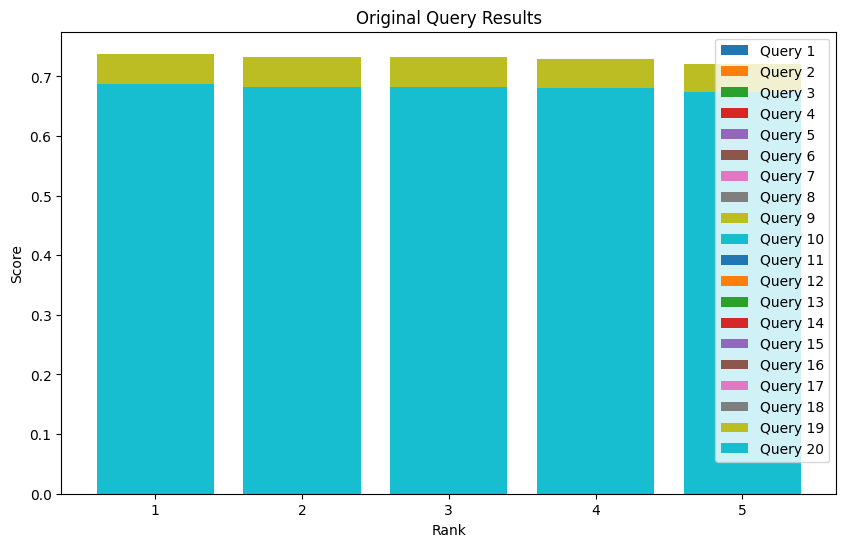

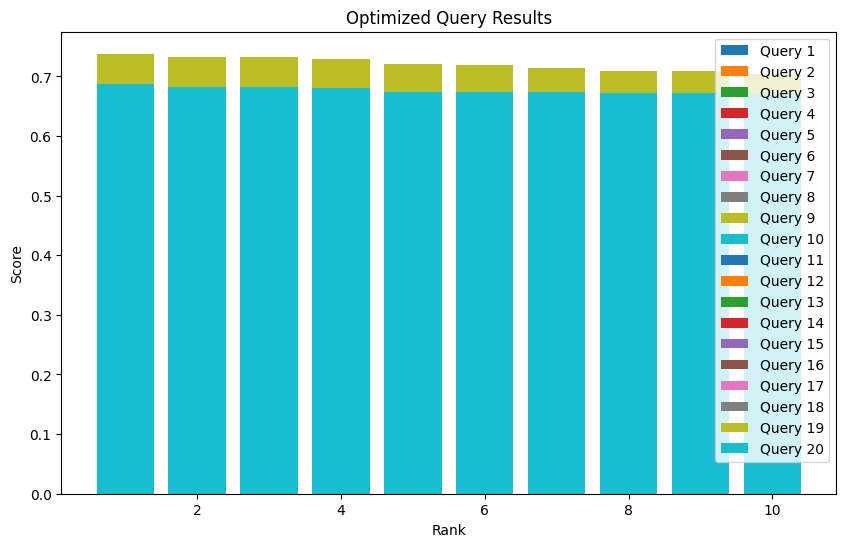

In [35]:
import matplotlib.pyplot as plt

# Plotting the results of the original query
plt.figure(figsize=(10, 6))
for i, result in enumerate(results):
    scores = [match['score'] for match in result["matches"]]
    plt.bar(range(1, len(scores) + 1), scores, label=f"Query {i+1}")

plt.title('Original Query Results')
plt.xlabel('Rank')
plt.ylabel('Score')
plt.legend()
plt.show()

# Plotting the results of the optimized query
plt.figure(figsize=(10, 6))
for i, result in enumerate(optimized_results):
    scores = [match['score'] for match in result["matches"]]
    plt.bar(range(1, len(scores) + 1), scores, label=f"Query {i+1}")

plt.title('Optimized Query Results')
plt.xlabel('Rank')
plt.ylabel('Score')
plt.legend()
plt.show()


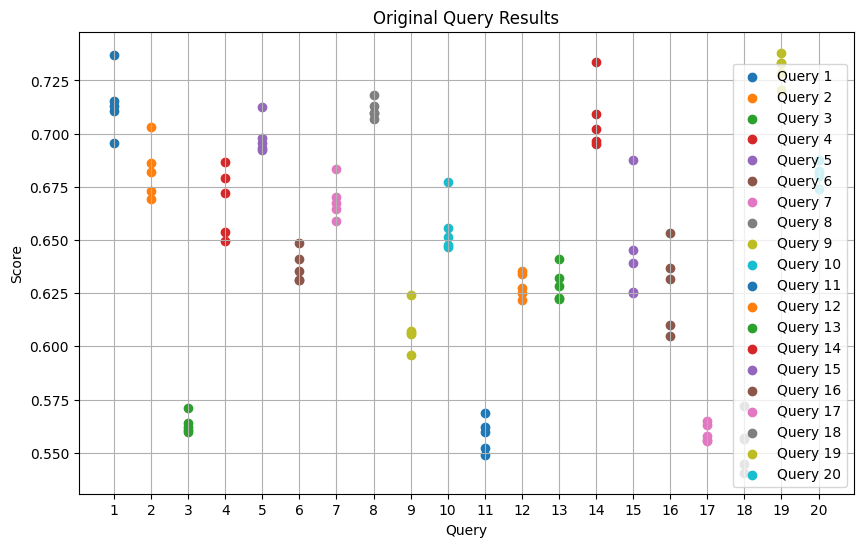

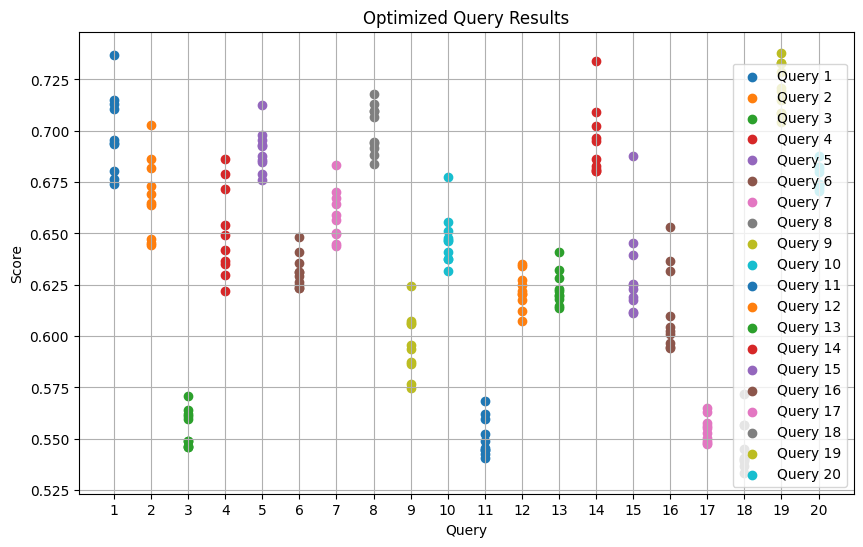

In [36]:
import matplotlib.pyplot as plt

# Plotting the results of the original query
plt.figure(figsize=(10, 6))
for i, result in enumerate(results):
    scores = [match['score'] for match in result["matches"]]
    plt.scatter([i+1] * len(scores), scores, label=f"Query {i+1}")

plt.title('Original Query Results')
plt.xlabel('Query')
plt.ylabel('Score')
plt.xticks(range(1, len(results) + 1))
plt.legend()
plt.grid(True)
plt.show()

# Plotting the results of the optimized query
plt.figure(figsize=(10, 6))
for i, result in enumerate(optimized_results):
    scores = [match['score'] for match in result["matches"]]
    plt.scatter([i+1] * len(scores), scores, label=f"Query {i+1}")

plt.title('Optimized Query Results')
plt.xlabel('Query')
plt.ylabel('Score')
plt.xticks(range(1, len(results) + 1))
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# Load data from CSV
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
